# Potential method for calculating Betti numbers

### 1. Input
The first problem we'll be dealing with is how to get an *input* in to the code to begin with. I propose using a class `Graph` from the package **NetworkX** which can create a graph easily and simply with built-in methods such as `add_edge`, `add_node`, and `draw`, and then creating a way to convert this to a matrix over field $\mathbb{F}_2$. This way, we can make it simple to create test graphs without having to create the matrices by hand. This could look like this:

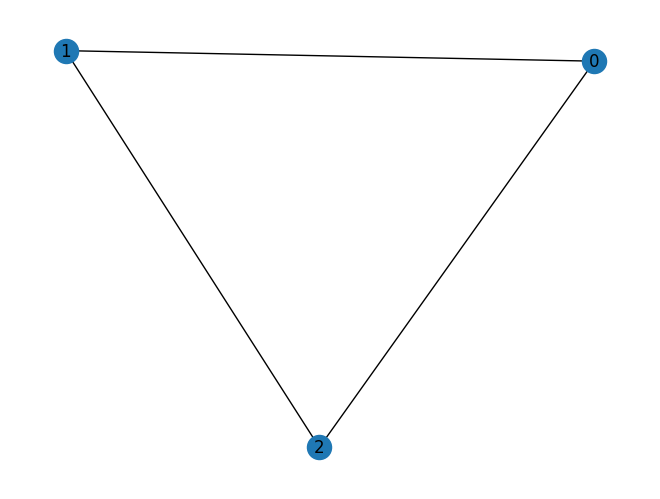

In [44]:
import networkx as nx # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore

G = nx.Graph()
G.add_nodes_from([0, 1, 2])
G.add_edges_from([(0, 1), 
                  (0, 2), 
                  (1, 2)])

nx.draw(G, with_labels=True)
plt.show()

You can even add colors to this representation.

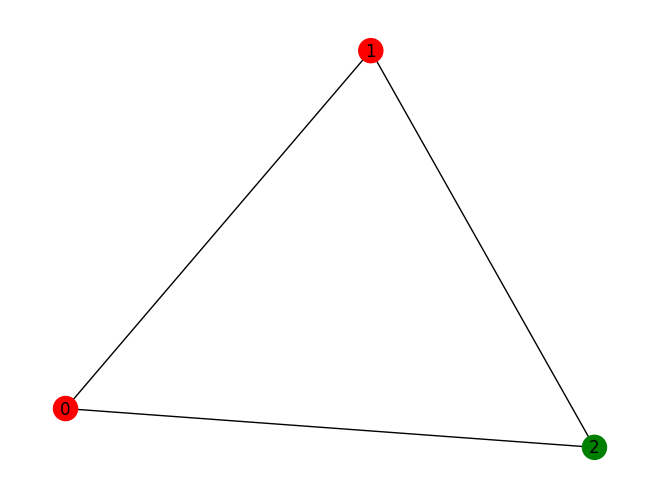

In [45]:
groupA = {0, 1}
groupB = {2}

node_colors = []

for v in G.nodes:
    if v in groupA:
        node_colors.append('red')
    if v in groupB:
        node_colors.append('green')

options = {
    'node_color': node_colors
}

nx.draw(G, with_labels = True, **options)
plt.show()

### 2. Determining Betti numbers


Since it's pretty simple to make a NetworkX graph, it might be good to make a `GraphMatrix` class that can take that class and do some basic functions on it. This could look like this:

In [46]:

from typing import TypeAlias

Graph: TypeAlias = nx.Graph
Matrix: TypeAlias = np.ndarray
ThreeCliqueList: TypeAlias = list[tuple[int, int, int]]
AdjMap: TypeAlias = dict[int, set[int]]
EdgeList: TypeAlias = list[tuple[int, int]]


def get_edges(G: Graph) -> EdgeList:
    return sorted((min(u, v), max(u, v)) for u, v in G.edges)

def rank_over_GF2(matrix: Matrix) -> int:
    """
    Finds rank of matrix over GF(2). `matrix` must only contain 0/1 values.
    """
    matrix: Matrix = (matrix.copy() & 1).astype(np.uint8)
    nrows: int
    mcols: int
    nrows, mcols = matrix.shape
    
    rank: int = 0
    start_row: int = 0
    
    for col_index in range(mcols):
        pivot_index: int | None = None
        for row_index in range(start_row, nrows):
            if matrix[row_index, col_index] == 1:
                pivot_index = row_index
                break
        if pivot_index is None:
            continue
        
        if pivot_index != start_row:
            matrix[[start_row, pivot_index]] = matrix[[pivot_index, start_row]]
            
        for row_index in range(nrows):
            if row_index != start_row and matrix[row_index, col_index] == 1:
                matrix[row_index, :] ^= matrix[start_row, :]
                
        rank += 1
        start_row += 1
        
        if row_index == nrows:
            break
        
    return rank

def get_edge_space(G: Graph) -> Matrix:
    """
    Method `graph_matrix` is for taking any NetworkX graph and turning it into a edge space represented by a matrix, or a **NumPy Array**
    """
    matrix: list[list[int]] = []
    for edge in G.edges:
        vectorized = [0 for _ in list(G.nodes)]
        for v in edge:
            vectorized[v] = 1
        matrix.append(vectorized)
    return np.array(matrix).transpose()

def get_3_clique_space(G: Graph) -> Matrix:
    """
    
    """
    edges: EdgeList = get_edges(G)
    matrix: list[list[int]] = []
    
    adj: dict[int, set[int]] = GraphMatrix.produce_adjacency(G)
    triangles: ThreeCliqueList = GraphMatrix.triangles_from_adj(adj)
    
    for t in triangles:
        vectorized = [0 for _ in edges]
        for i in range(len(edges)):
            if edges[i][0] in t and edges[i][1] in t:
                vectorized[i] = 1
        matrix.append(vectorized)
    return np.array(matrix).transpose()
        
    
class GraphMatrix:
    """
    Takes a NetworkX graph as input and performs some basic methods to it.
    """
    def __init__(self, graph: Graph) -> None:
        """
        Input graph must be a NetworkX graph, and vertices must have form 0, 1, 2, ...
        """
        self.graph: Graph = graph
        self.vertices: set[int] = set(self.graph.nodes)
        self.edges: list[tuple[int, int]] = sorted((min(u, v), max(u, v)) for u, v in self.graph.edges)
        self.edge_space: Matrix = get_edge_space(self.graph) % 2
        self.adjacency: AdjMap = self.produce_adjacency(self.graph)
        self.three_cliques: ThreeCliqueList = sorted(self.triangles_from_adj(self.adjacency))
        
    @staticmethod
    def produce_adjacency(G: Graph) -> AdjMap:
        """
        Takes the vertices of the graph and produces a dictionary of adjacent vertices.
        """
        adj: dict[int, set[int]] = {v : set() for v in G.nodes}
        for u, v in G.edges:
            adj[u].add(v)
            adj[v].add(u)
        return adj
    
    def dimension_kernel_boundary_1(self) -> int:
        """
        This finds the rank of the kernel of the map C1 -> C0
        """
        return len(self.edges) - rank_over_GF2(self.edge_space)
    
    @staticmethod
    def triangles_from_adj(adj: AdjMap) -> ThreeCliqueList:
        """
        This method finds all the three cliques in the graph by first using the adjacency map.
        """
        triangles: ThreeCliqueList = []
        for u in adj:
            for v in adj[u]:
                if v <= u:
                    continue
                common: set[int] = adj[u] & adj[v]
                for w in common:
                    if w <= v:
                        continue
                    triangles.append(tuple(sorted((u, v, w))))
        return triangles
            


Note that this class doesn't allow for different colored nodes.

In [47]:
graph = GraphMatrix(G)

# This will print the basis for the edge space
print(graph.edge_space)

[[1 1 0]
 [1 0 1]
 [0 1 1]]


In [48]:
# This will print the dimension of the kernel of the 1-dimensional boundary map, for our graph G that is 1
print(graph.dimension_kernel_boundary_1())

1


### Now to try a different graph:

![](image.png)

In [49]:
v = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
e = [(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (3, 5), (4, 5), (5, 6), (6, 7), (6, 9), (7, 8), (8, 9)]

N = nx.Graph()
N.add_nodes_from(v)
N.add_edges_from(e)

complex = GraphMatrix(N)

print(f"The edge space this graph produces is:\n{complex.edge_space}\n")
print(f"The adjacency map is:\n{complex.adjacency}\n")
print(f"The dimension of the kernel of the map C1 -> C0 is: {complex.dimension_kernel_boundary_1()}\n")
print(f"The three cliques in the graph are:\n{complex.three_cliques}")




The edge space this graph produces is:
[[1 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 1 0 1]]

The adjacency map is:
{0: {1, 2}, 1: {0, 2}, 2: {0, 1, 3}, 3: {2, 4, 5}, 4: {3, 5}, 5: {3, 4, 6}, 6: {9, 5, 7}, 7: {8, 6}, 8: {9, 7}, 9: {8, 6}}

The dimension of the kernel of the map C1 -> C0 is: 3

The three cliques in the graph are:
[(0, 1, 2), (3, 4, 5)]


### 3. Implementing to Evaluate $\beta_1$

So I've already made code to find the rank over $\mathbb{F}_2$ of any matrix, and code to find the basis of $C_1$ and $C_2$, now let's put it all together to test the code. We will use the following graph where $\beta_1=5$.

![](image1.png)

The number of 1-dimensional holes in our graph nG is: 5


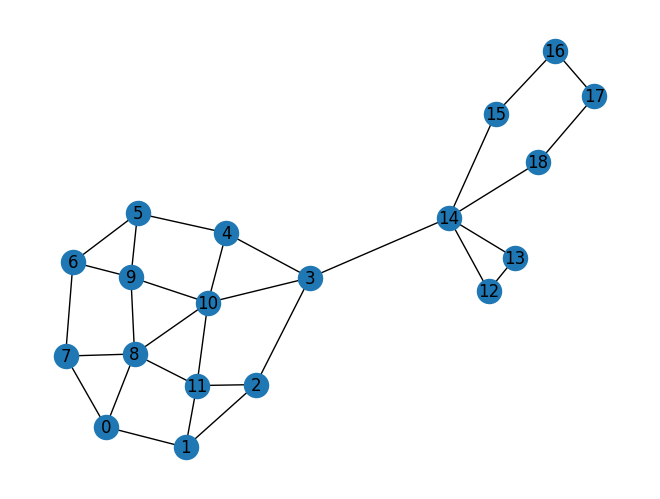

In [50]:
vertices = [i for i in range(19)]
edges = [
    (0,1),
    (0, 7),
    (0, 8),
    (1, 11),
    (1, 2),
    (2, 3),
    (2, 11),
    (3, 4),
    (3, 10),
    (3, 14),
    (4, 5),
    (4, 10),
    (5, 6),
    (5, 9),
    (6, 7),
    (6, 9),
    (7, 8),
    (8, 9),
    (8, 10),
    (8, 11),
    (9, 10),
    (10, 11),
    (12, 13),
    (12, 14),
    (13, 14),
    (14, 15),
    (14, 18),
    (15, 16),
    (16, 17),
    (17, 18),
]

nG = nx.Graph()
nG.add_nodes_from(vertices)
nG.add_edges_from(edges)

nx.draw(nG, with_labels=True)

def calculate_B1(G: Graph):
    g = GraphMatrix(G)
    rkb1 = g.dimension_kernel_boundary_1()
    rb2 = rank_over_GF2(get_3_clique_space(G))
    
    return rkb1 - rb2

print(f"The number of 1-dimensional holes in our graph nG is: {calculate_B1(nG)}")
plt.show()